In [1]:
import rioxarray
import rasterio
import numpy as np
import qinfer
import numpy.linalg as la
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import geopandas as gpd
from shapely.geometry.point import Point
import shapely.affinity
import subprocess
from osgeo import gdal
import pygeos
import json
import os
import pandas as pd
from tqdm import tqdm
import requests
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import esda
import libpysal
from scipy import stats

/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/qinfer/parallel.py:51: UserWarning: Could not import IPython parallel. Parallelization support will be disabled.
  warnings.warn(


In [2]:
mi = gpd.read_file('./output/TAS_F_mi.geojson')
mi.T

0  \
ID                                           PA00007   
LAT                                        39.923653   
LON                                       -76.754503   
NAME                            YORK INDIAN ROCK DAM   
LIBRARY_ID                                      5486   
LIBRARY_TYPE                               dam_study   
I_no_hs_dip                                  0.16019   
pval_no_hs_dip                                   0.0   
I_poverty                                   0.169403   
pval_poverty                                     0.0   
I_unprof_eng                                0.097241   
pval_unprof_eng                                  0.0   
I_mobile_home                              -0.050604   
pval_mobile_home                                 0.0   
I_no_vehicle                                0.143041   
pval_no_vehicle                                  0.0   
I_unemployed                                0.135499   
pval_unemployed                                  0.0   
I_age65                                    -0.050972   
pval_age65                                       0.0   
geometry          POINT (-76.754503299 39.923652662)   

                                                       1  \
ID                                               PA00010   
LAT                                            40.851389   
LON                                           -75.639617   
NAME                                      BELTZVILLE DAM   
LIBRARY_ID                                          6207   
LIBRARY_TYPE                                   dam_study   
I_no_hs_dip                                      0.05082   
pval_no_hs_dip                                       0.0   
I_poverty                                       0.026997   
pval_poverty                                         0.0   
I_unprof_eng                                    0.002065   
pval_unprof_eng                                 0.281494   
I_mobile_home                                   0.027982   
pval_mobile_home                                     0.0   
I_no_vehicle                                   -0.011412   
pval_no_vehicle                                 0.001079   
I_unemployed                                    0.016285   
pval_unemployed                                 0.000006   
I_age65                                         -0.00532   
pval_age65                                      0.064316   
geometry          POINT (-75.6396171119999 40.851388942)   

                                                        2  \
ID                                                GA01702   
LAT                                             34.357758   
LON                                            -82.821428   
NAME                                         HARTWELL DAM   
LIBRARY_ID                                            378   
LIBRARY_TYPE                                    dam_study   
I_no_hs_dip                                     -0.094379   
pval_no_hs_dip                                        0.0   
I_poverty                                       -0.087701   
pval_poverty                                          0.0   
I_unprof_eng                                    -0.021678   
pval_unprof_eng                                       0.0   
I_mobile_home                                   -0.013983   
pval_mobile_home                                 0.000541   
I_no_vehicle                                    -0.080824   
pval_no_vehicle                                       0.0   
I_unemployed                                    -0.083437   
pval_unemployed                                       0.0   
I_age65                                          0.153916   
pval_age65                                            0.0   
geometry          POINT (-82.82142792600001 34.357758277)   

                                                       3  \
ID                                           AR00173S002   
LAT                               

In [3]:
lm = gpd.read_file('./output/TAS_F_lm.geojson')
lm.head(1)

no_hs_dip  poverty  unprof_eng  mobile_home  no_vehicle  unemployed  age65  \
0        6.0     11.0         1.0          4.3         5.1         3.9   12.4   

    Dam_ID            GEOID  Class LISA_no_hs_dip LISA_poverty  \
0  PA00007  420410101001000      1        Not_Sig      Not_Sig   

  LISA_unprof_eng LISA_mobile_home LISA_no_vehicle LISA_unemployed LISA_age65  \
0         Not_Sig          Not_Sig         Not_Sig         Not_Sig    Not_Sig   

                                            geometry  
0  POLYGON ((-76.91615 40.31599, -76.91612 40.316...

<AxesSubplot: >

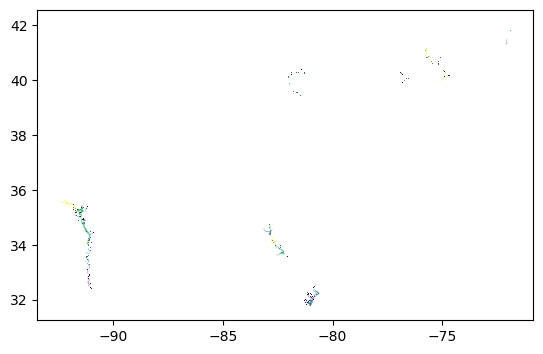

In [4]:
fim = gpd.read_file('./output/TAS_F_fim.geojson')
fim.plot('value')

In [10]:
ellipse = gpd.read_file('./output/TAS_F_ellipse.geojson')
ellipse

Dam_ID                                           geometry
0      PA00007  POLYGON ((-77.05100 40.36096, -77.03539 40.373...
1      PA00010  POLYGON ((-75.69835 41.00461, -75.66938 41.025...
2      GA01702  POLYGON ((-83.25292 34.90239, -83.21036 34.922...
3  AR00173S002  POLYGON ((-92.14573 36.58444, -92.07682 36.594...
4      CT00502  POLYGON ((-71.94583 42.11591, -71.93135 42.110...
5      PA00007  POLYGON ((-77.05100 40.36096, -77.03539 40.373...
6      PA00008  POLYGON ((-75.80129 41.11261, -75.78313 41.132...
7      OH00012  POLYGON ((-81.96329 40.49848, -81.92089 40.527...

PA00007


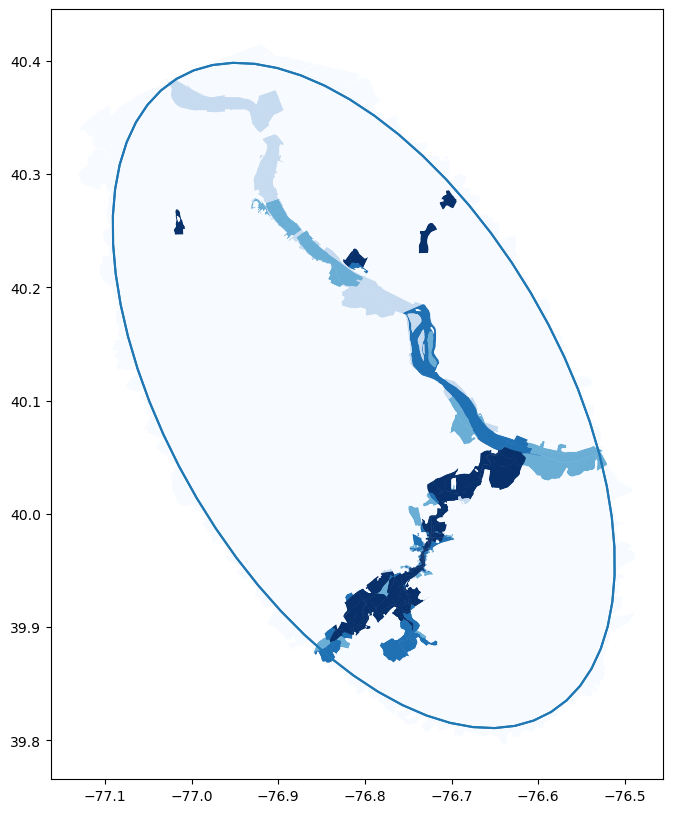

PA00010


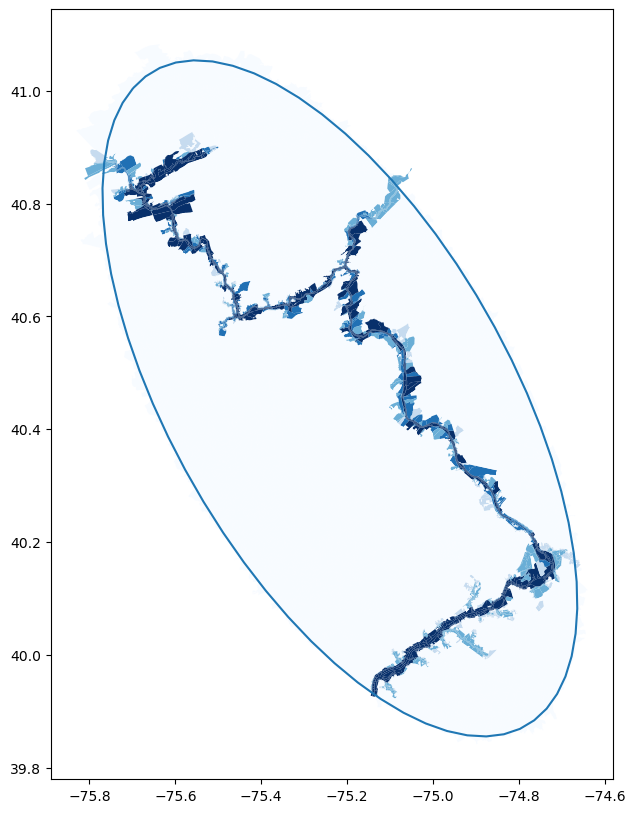

GA01702


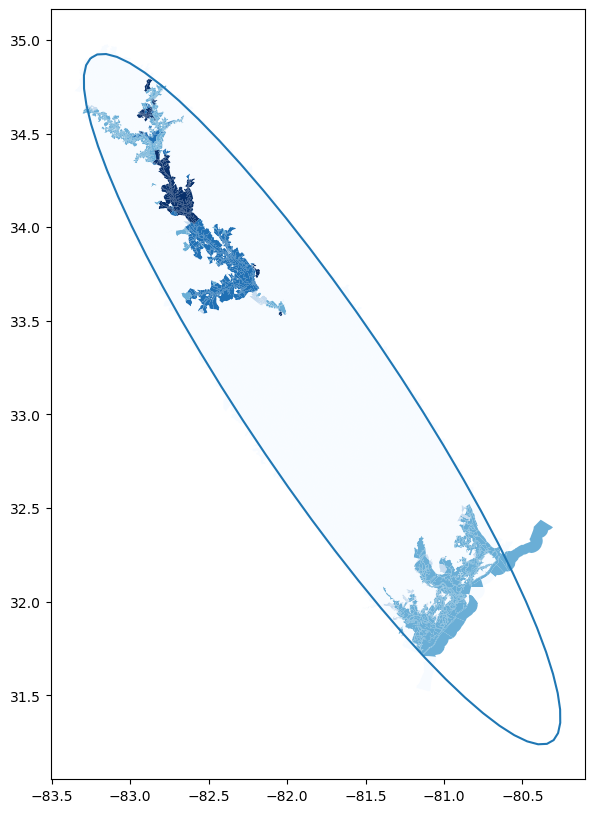

AR00173S002


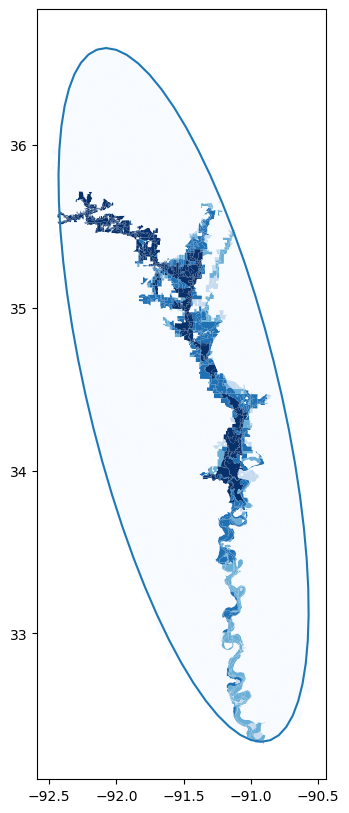

CT00502


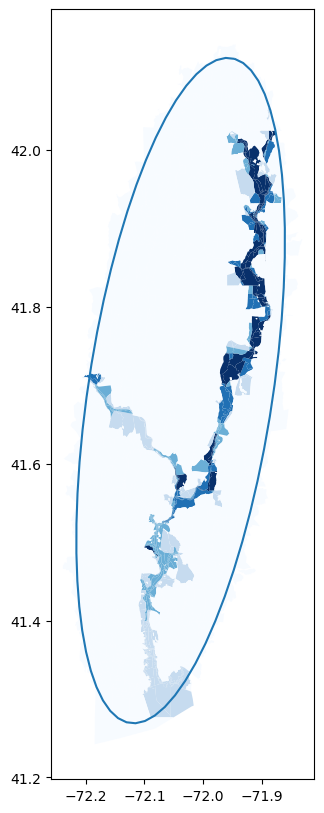

PA00007


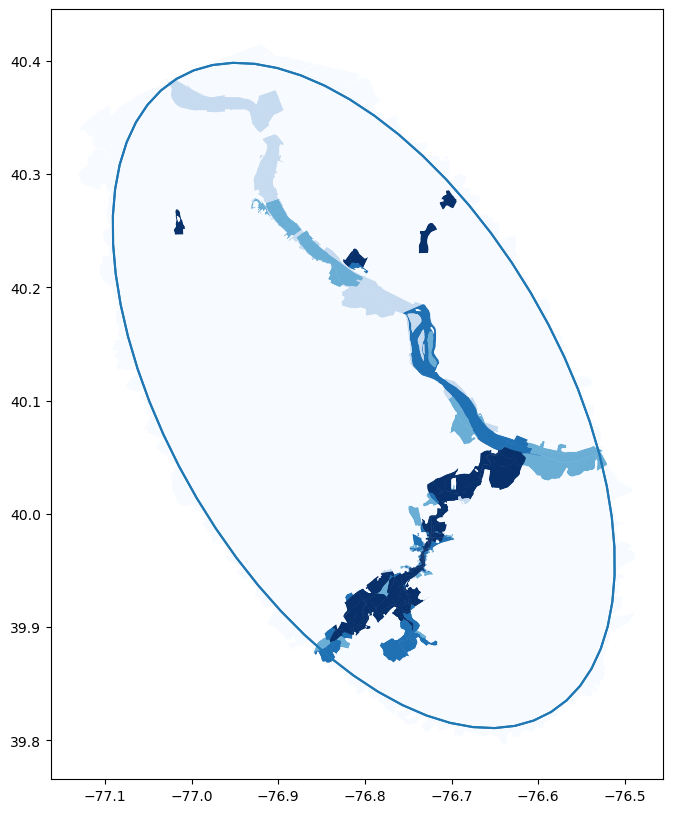

PA00008


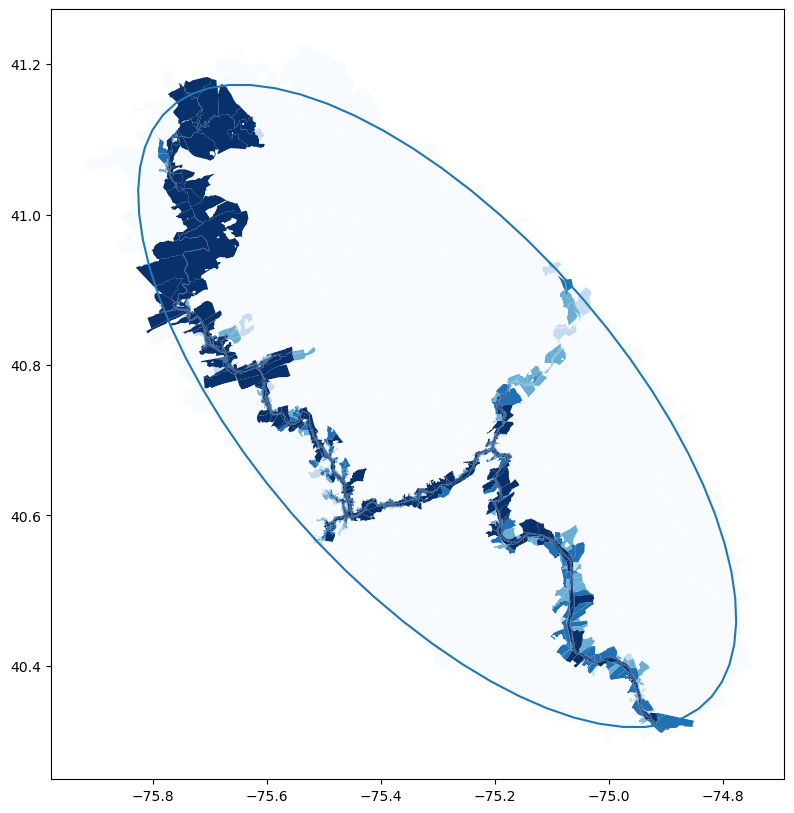

OH00012


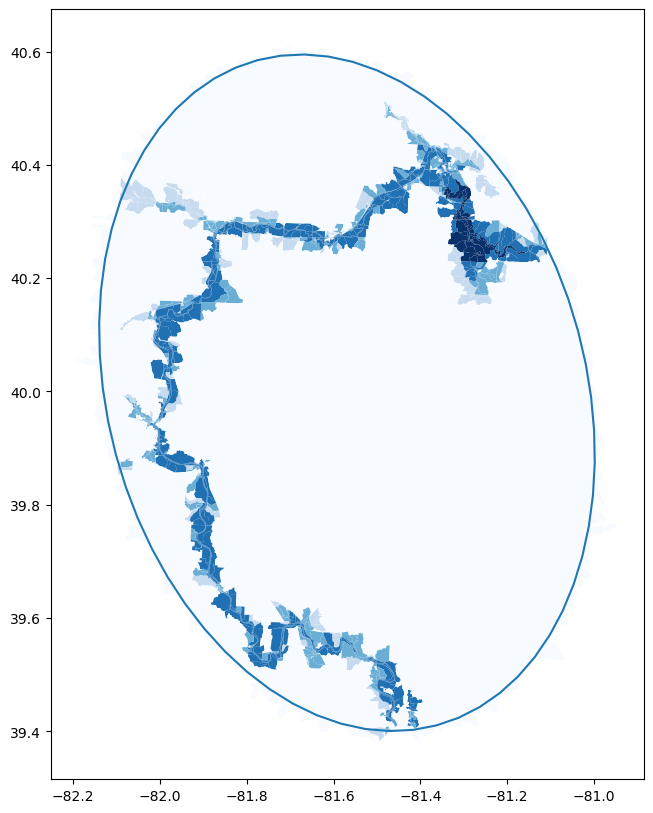

In [13]:
for dam_id in ellipse['Dam_ID']:
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    print(dam_id)
    lm.loc[lm['Dam_ID'] == dam_id].plot('Class', ax=ax, cmap='Blues')
    ellipse.loc[ellipse['Dam_ID'] == dam_id].boundary.plot(ax=ax)
    plt.show()


In [14]:
# Import list of dams
fed_dams = requests.get('https://fim.sec.usace.army.mil/ci/fim/getAllEAPStructure').json()
fed_dams = pd.DataFrame(fed_dams)
fed_dams = gpd.GeoDataFrame(fed_dams, geometry=gpd.points_from_xy(fed_dams['LON'], fed_dams['LAT'], crs="EPSG:4326"))
fed_dams = fed_dams.loc[fed_dams['ID'].isin(lm['Dam_ID'])]
print(fed_dams.shape[0])
fed_dams

7


ID        LAT        LON                              NAME  \
179      PA00008  41.112248 -75.721730             FRANCIS E. WALTER DAM   
185      OH00012  40.269079 -81.276567                    CLENDENING DAM   
268      GA01702  34.357758 -82.821428                      HARTWELL DAM   
288      PA00010  40.851389 -75.639617                    BELTZVILLE DAM   
295      PA00007  39.923653 -76.754503              YORK INDIAN ROCK DAM   
297  AR00173S002  35.475443 -92.089438  Greers Ferry Dam - Saddle Dike 2   
388      CT00502  41.945915 -71.898616                 WEST THOMPSON DAM   

     LIBRARY_ID LIBRARY_TYPE                    geometry  
179         359    dam_study  POINT (-75.72173 41.11225)  
185         748    dam_study  POINT (-81.27657 40.26908)  
268         378    dam_study  POINT (-82.82143 34.35776)  
288        6207    dam_study  POINT (-75.63962 40.85139)  
295        5486    dam_study  POINT (-76.75450 39.92365)  
297        5467    dam_study  POINT (-92.08944 35.47544)  
388        1509    dam_study  POINT (-71.89862 41.94592)

In [15]:
census_attr_dic = {'no_hs_dip': 'group(B06009)',     # Percentage of people over 25 without high school diploma
                    'poverty': 'group(B17001)',      # Percentage of people below the poverty level
                    'unprof_eng': 'group(B16005)',   # Percentage of resident with no proficient English
                    'mobile_home': 'DP04_0014PE',    # Percentage of mobile homes estimate
                    'no_vehicle': 'DP04_0058PE',     # Percentage of housholds without vehicle available estimate
                    'unemployed': 'DP03_0009PE',   # Unemployment Rate estimate
                    'age65': 'S0101_C02_030E'        # Percentage of person aged 65 and older estimate
                    }

census_attr_dic.keys()

dict_keys(['no_hs_dip', 'poverty', 'unprof_eng', 'mobile_home', 'no_vehicle', 'unemployed', 'age65'])

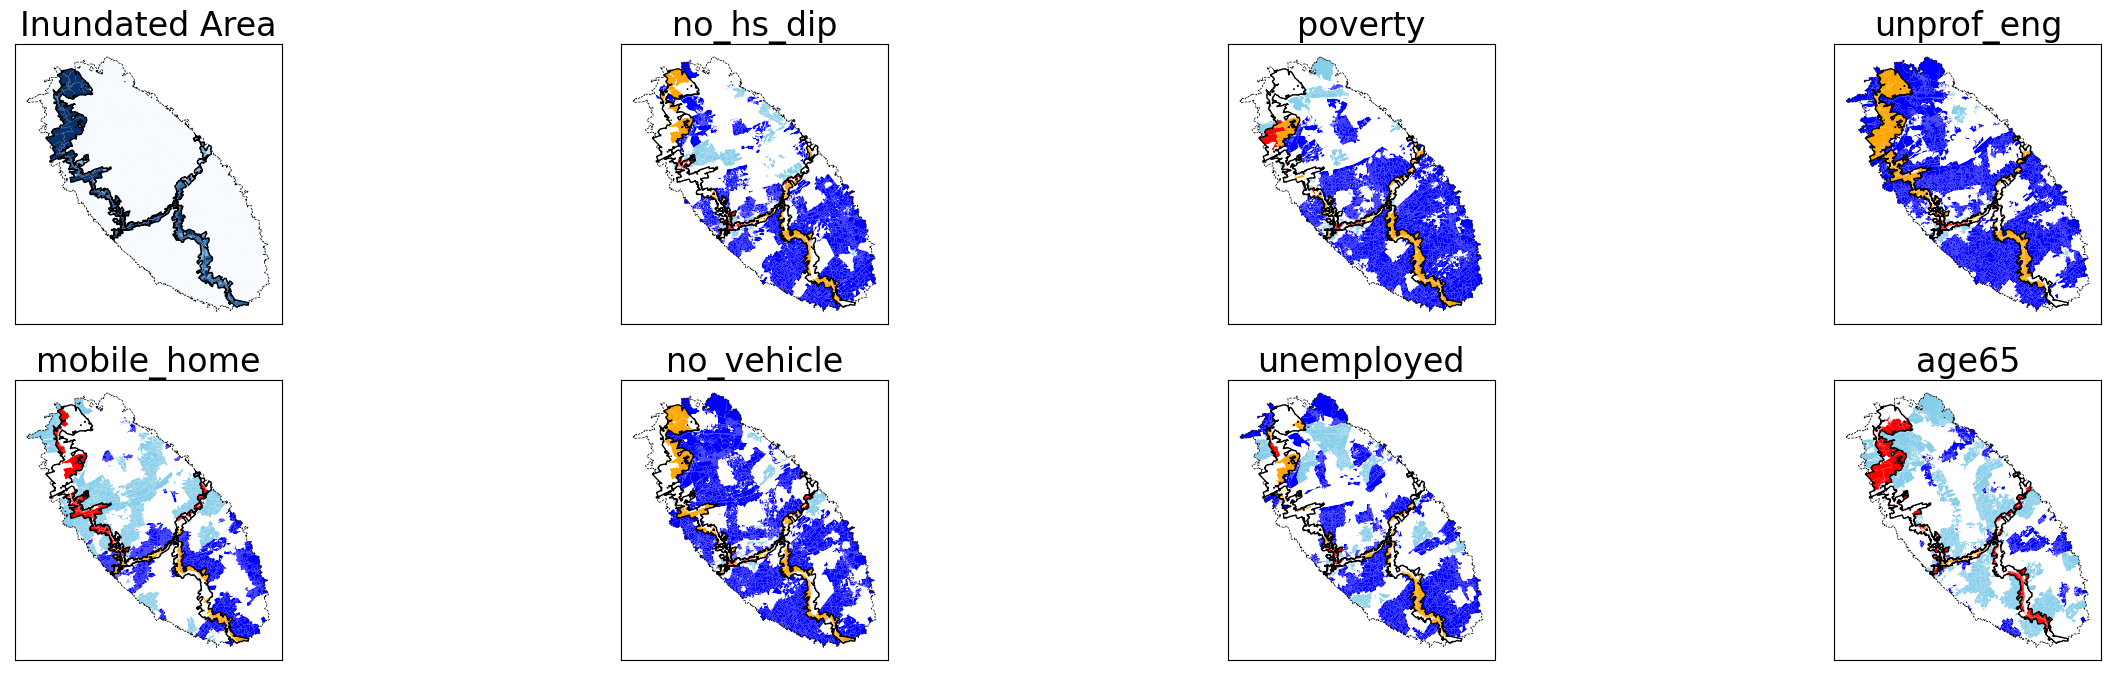

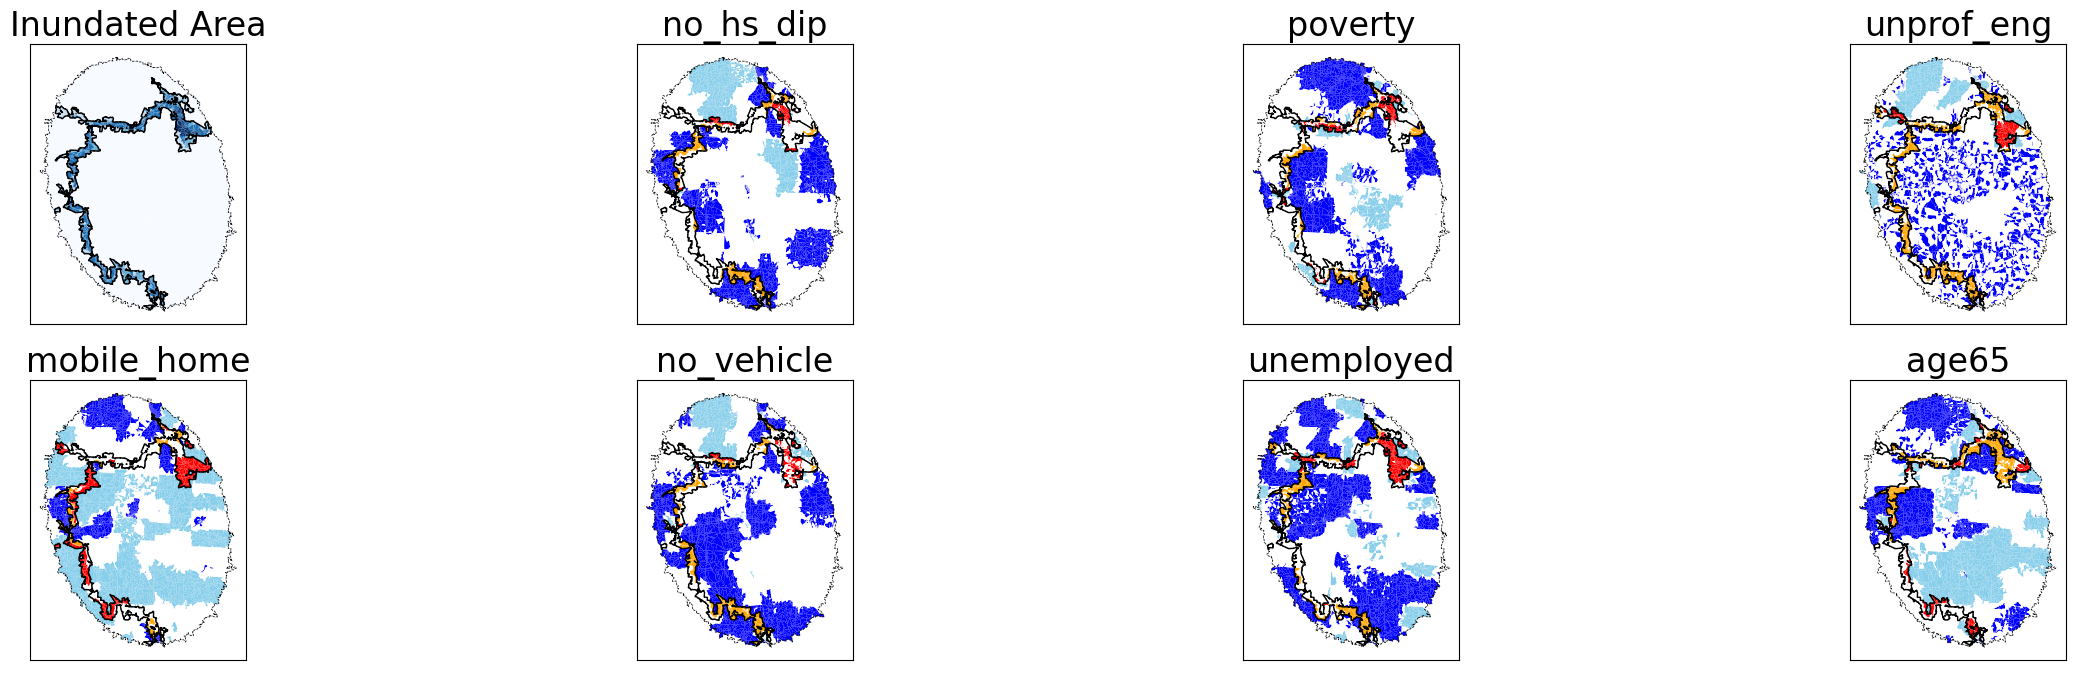

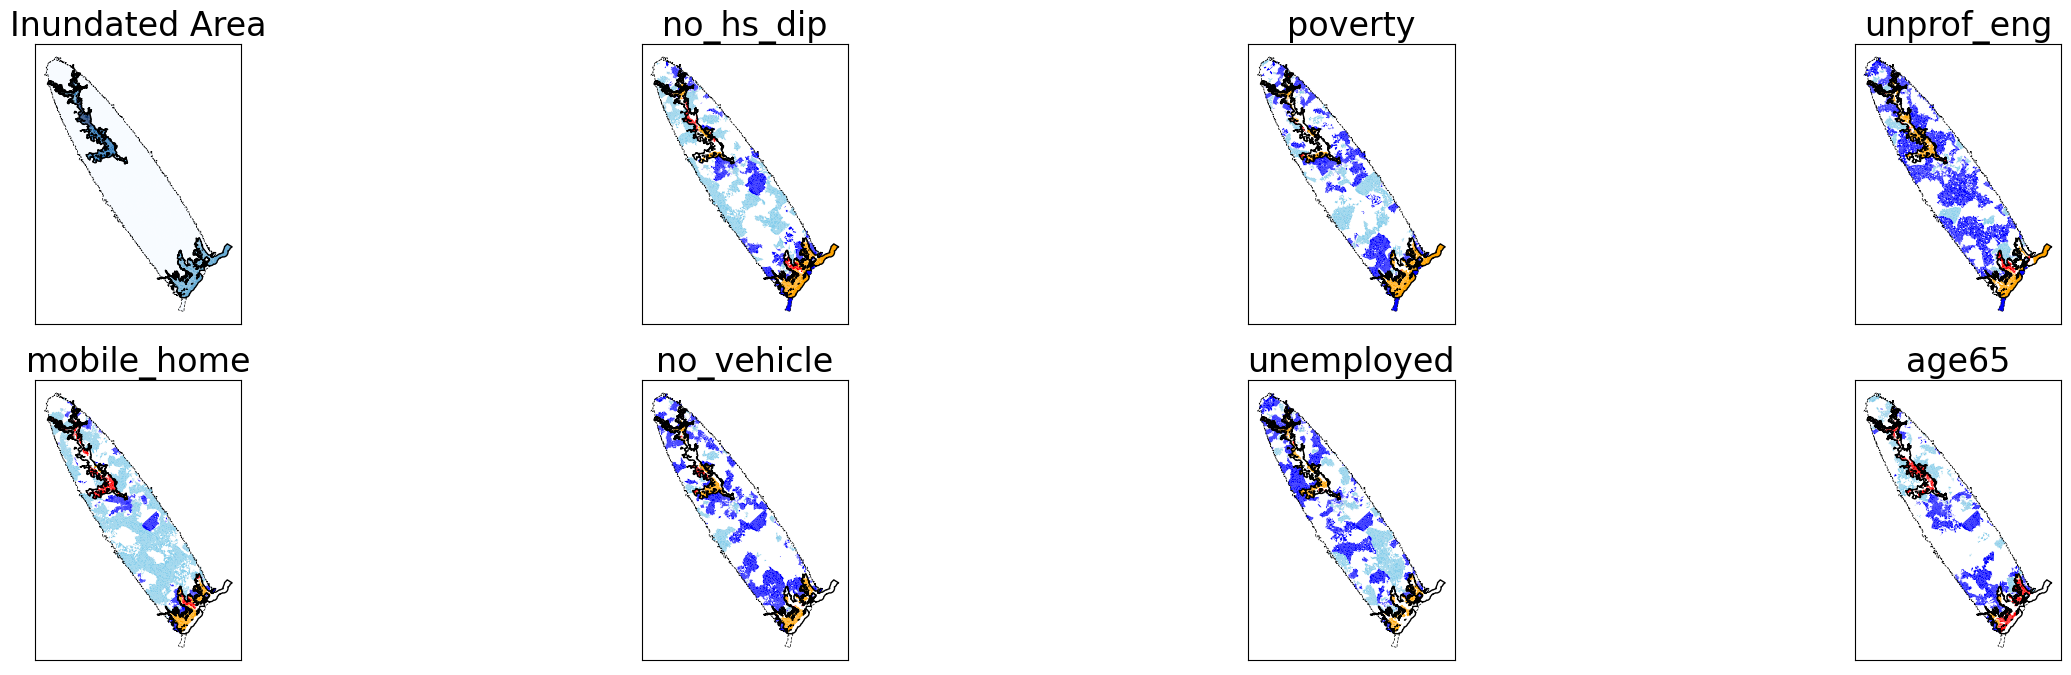

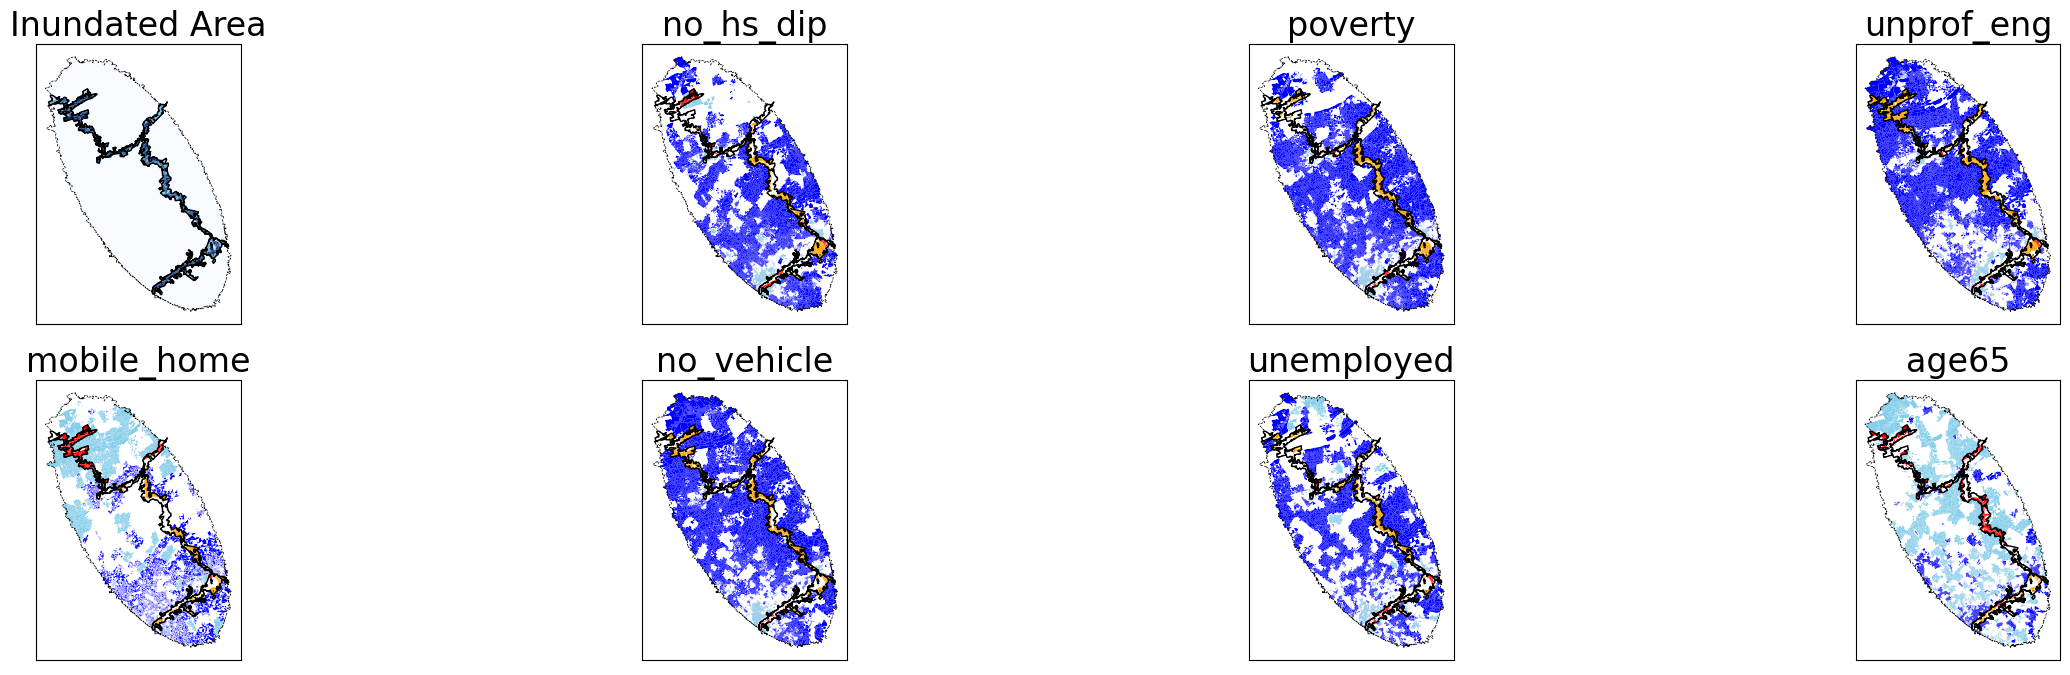

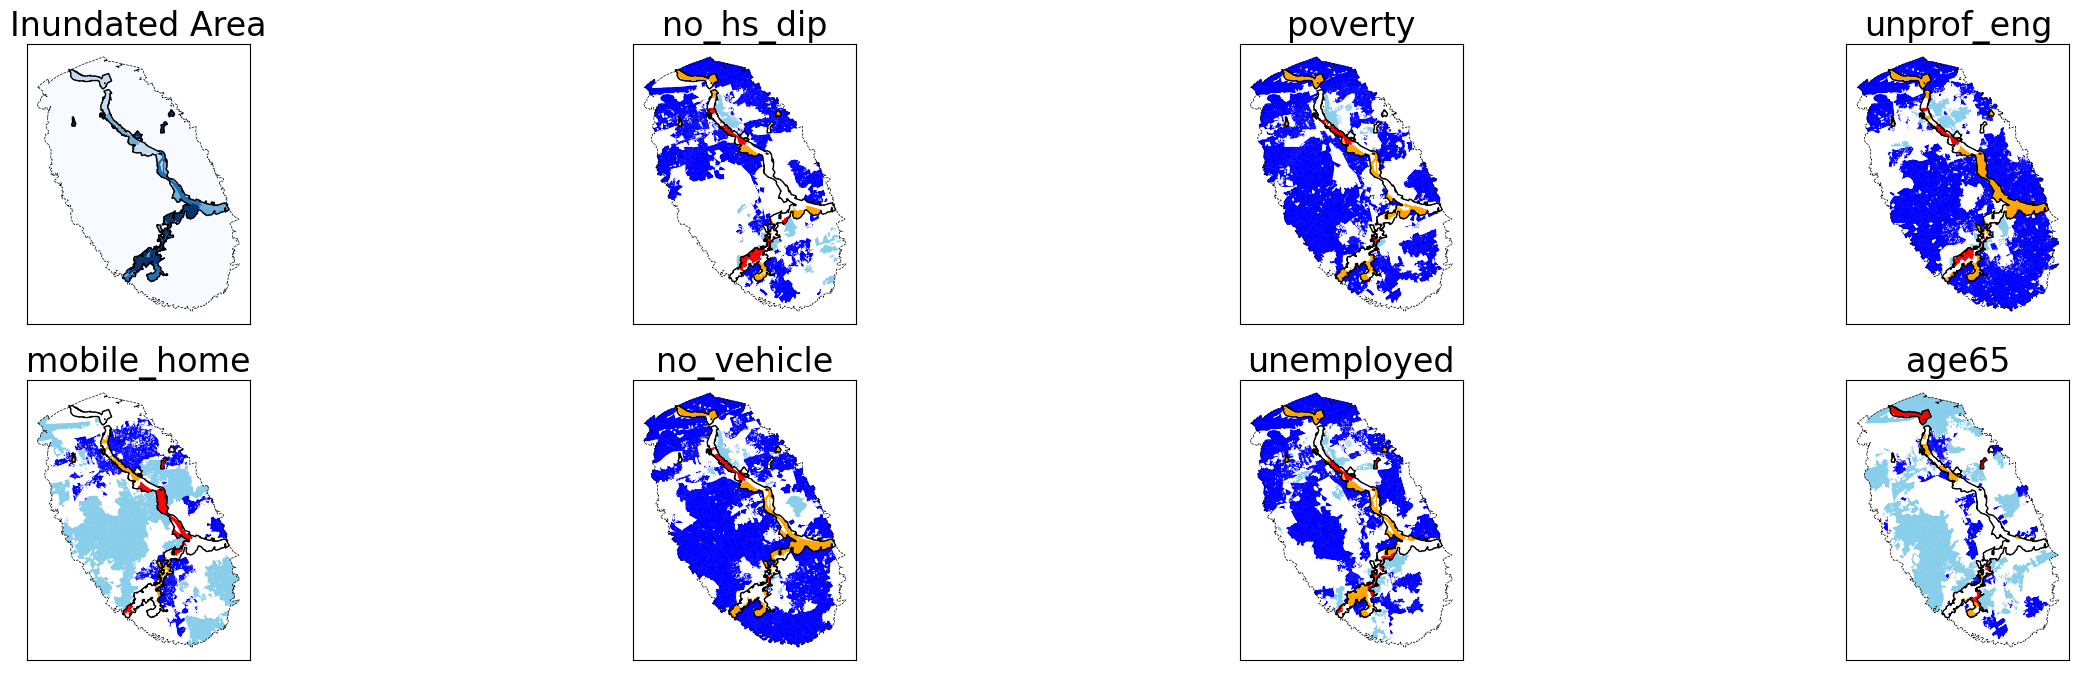

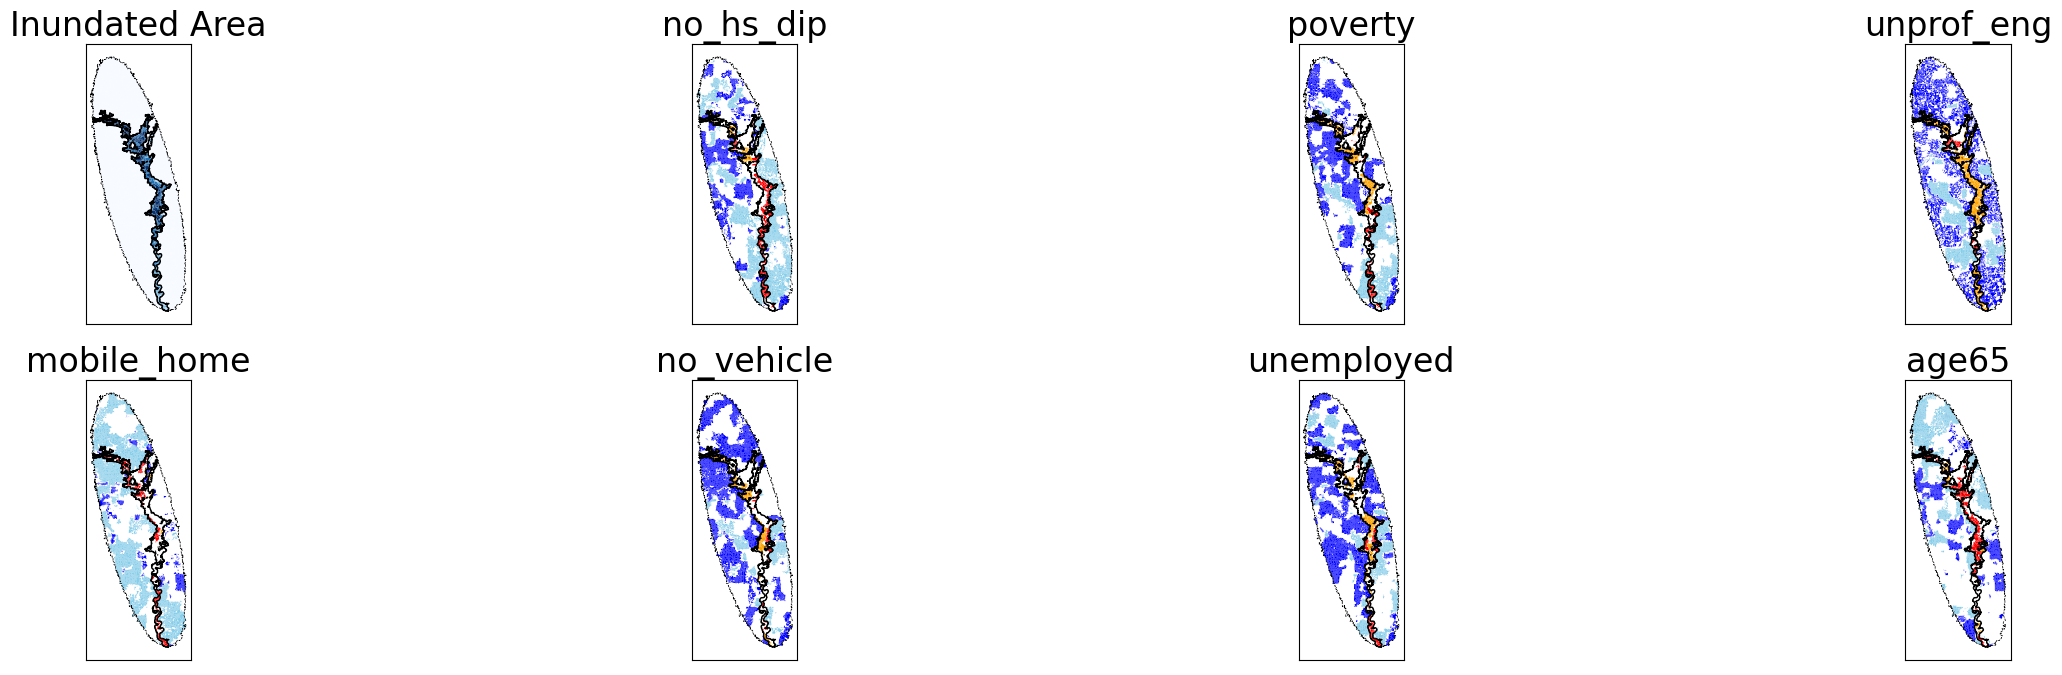

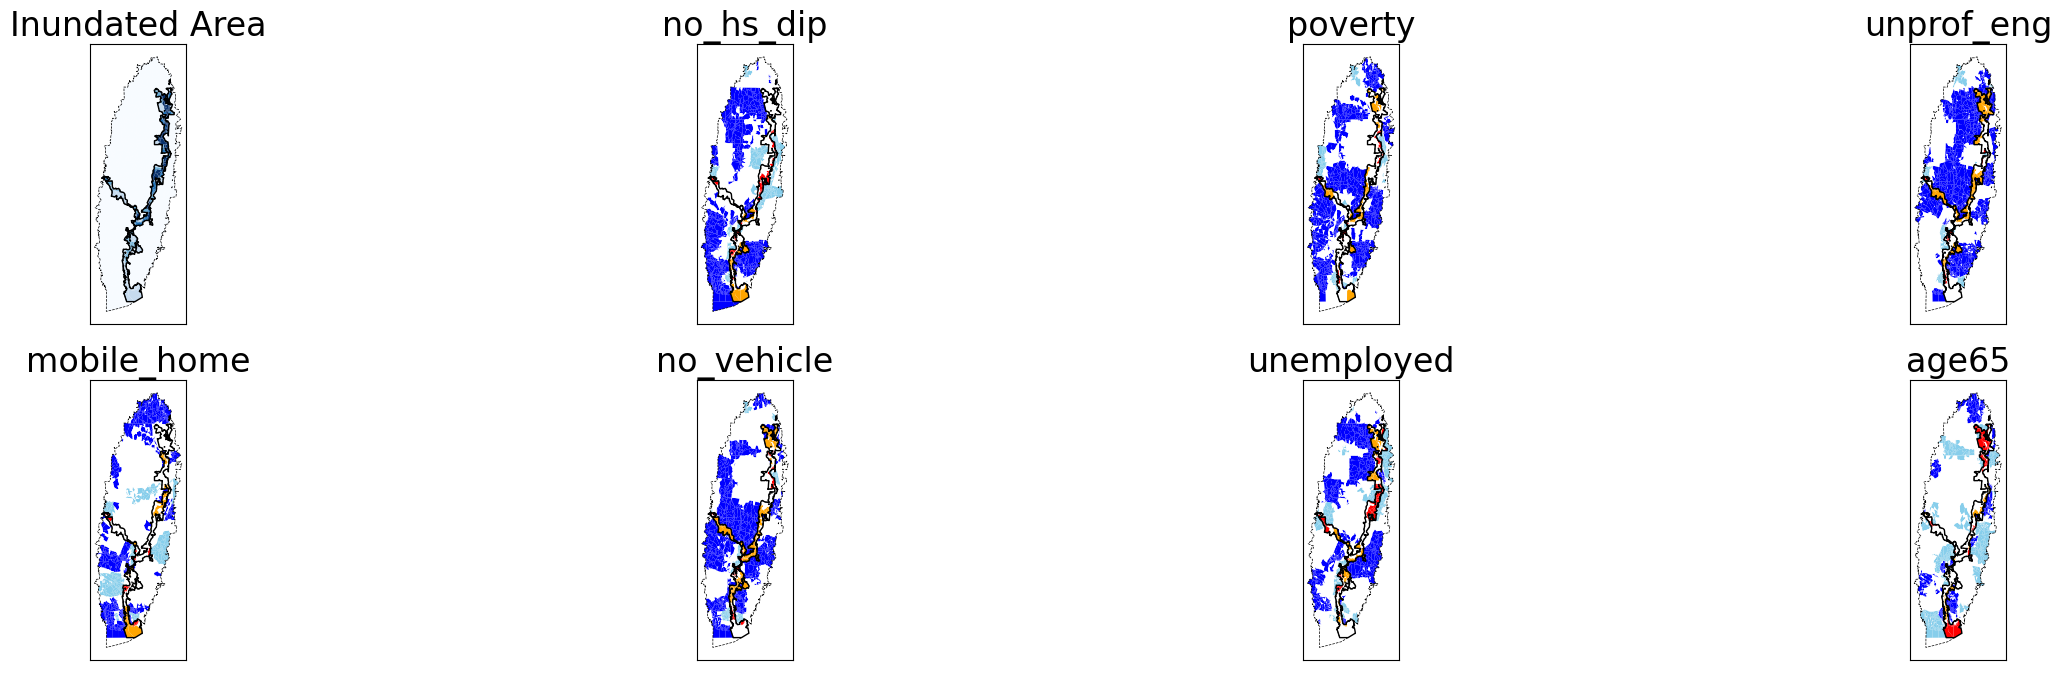

In [17]:
def plot_bivariate_moran_i_and_local_moran_i(dam_id, fim_geoid_gdf):
    fig, axes = plt.subplots(2, 4, figsize=(30, 8))
    ax = axes.reshape(-1)

    # Define geography related to each dam
    dam_area = fim_geoid_gdf.loc[fim_geoid_gdf['Dam_ID'] == dam_id].reset_index()

    benchmark_area = dam_area.loc[dam_area['Class'] == 0]
    inund_area = dam_area.loc[dam_area['Class'] > 0]
    benchmark_area_union = benchmark_area.dissolve(by='Dam_ID')
    inund_area_union = inund_area.dissolve(by='Dam_ID')

    fed_dams_focus = fed_dams.loc[fed_dams['ID'] == dam_id].reset_index()
    fed_dams_focus = fed_dams_focus.to_crs(epsg=5070)

    # Plot maps
    var_list = ['no_hs_dip', 'poverty', 'unprof_eng', 'mobile_home', 'no_vehicle', 'unemployed', 'age65']
    for m in range(8):
        if m == 0:
            fim_geoid_gdf[fim_geoid_gdf['Dam_ID'] == dam_id].plot('Class', cmap='Blues', ax=ax[m])
            ax[m].set_title(label="Inundated Area", fontsize=24)
        else:
            
            lisa_color = {'HH': 'red', 'LL': 'blue', 'HL': 'orange', 'LH': 'skyblue', 'Not_Sig': 'white'}
            
            for key in lisa_color.keys():
                fim_geoid_gdf.loc[(fim_geoid_gdf[f'LISA_{var_list[m-1]}'] == key) & (fim_geoid_gdf['Dam_ID'] == dam_id)].plot(ax=ax[m], color=lisa_color[key], legend=True)
            
            ax[m].set_title(label=f"{var_list[m-1]}", fontsize=24)

        benchmark_area_union.boundary.plot(ax=ax[m], color='black', lw=0.5, linestyle='dashed')
        inund_area_union.boundary.plot(ax=ax[m], color='black', lw=1)
        ax[m].get_xaxis().set_visible(False)
        ax[m].get_yaxis().set_visible(False)
        
    plt.show()
    
for dam_id in fed_dams['ID'].unique():

    plot_bivariate_moran_i_and_local_moran_i(dam_id, lm)